# Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,classification_report,f1_score
import io

In [2]:
train=pd.read_csv('/content/drive/MyDrive/Seminarska/Corona_NLP_train (1).csv',encoding='latin')
test=pd.read_csv('/content/drive/MyDrive/Seminarska/Corona_NLP_test (1).csv')

# Explore and visualize the data

In [3]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Shape - ни покажува која ни е големината на податочното множество

In [5]:
train.shape

(41157, 6)

In [6]:
test.shape

(3798, 6)

Со користење на info() ќе добиеме информација од кој тип ни се податоците на сите колони од dataset-от

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Го drop-нувам Username колоната бидејќи е исто како id колоната

In [8]:
train.drop('UserName',axis=1,inplace=True)

In [9]:
test.drop('UserName',axis=1,inplace=True)

Тука користам value_counts()

In [10]:
train['Location'].value_counts()

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

In [11]:
train['Location'].value_counts().nlargest(30)

London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
New Delhi, India           138
Atlanta, GA                126
New York                   126
Mumbai, India              109
Worldwide                  101
Lagos, Nigeria              99
Houston, TX                 98
Austin, TX                  98
Texas, USA                  98
London, UK                  96
Name: Location, dtype: int64

Тука се прикажани само 30 најголемите локации

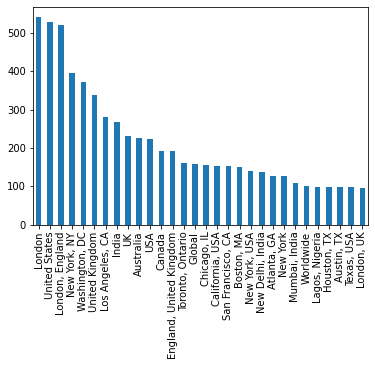

In [12]:
train['Location'].value_counts().nlargest(30).plot(kind='bar')

Во овој дел колоната "TweetAt" наместо да биде од тип object го ставам да биде од тип datetime, за понатаму да можам да прикажам само месецот и денот кога имал повеќе tweets

In [13]:
train["TweetAt"] = pd.to_datetime(train["TweetAt"])

In [14]:
tweets_per_day = train['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

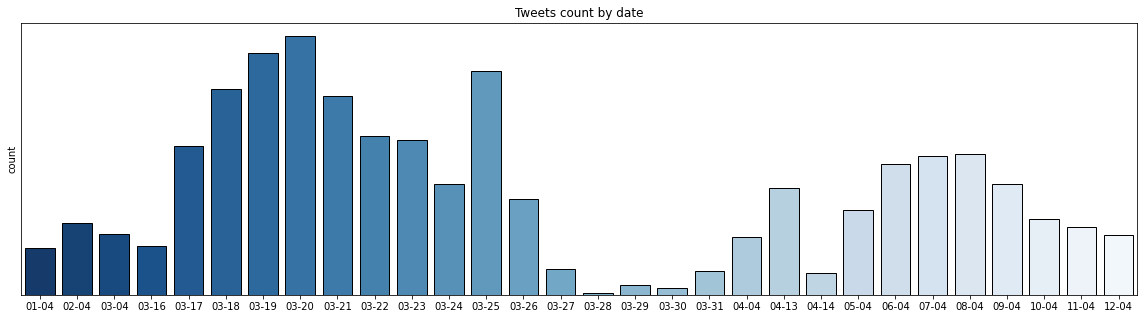

In [15]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_day,edgecolor = 'black',ci=False, palette='Blues_r')
plt.title('Tweets count by date')
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [16]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

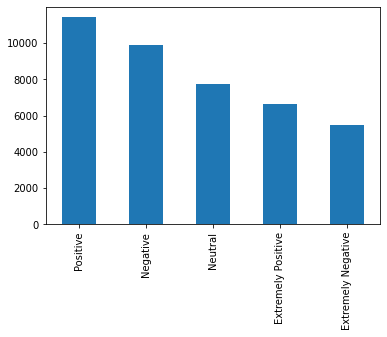

In [17]:
train['Sentiment'].value_counts().plot.bar()

#Preprocessing

Во овој дел се проверува дали има или нема *null* вредности

In [18]:
train.isnull().sum()

ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [19]:
test.isnull().sum()

ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

Ова ни помага да најдеме кои податоци недостигаат и колку проценти недостигаат

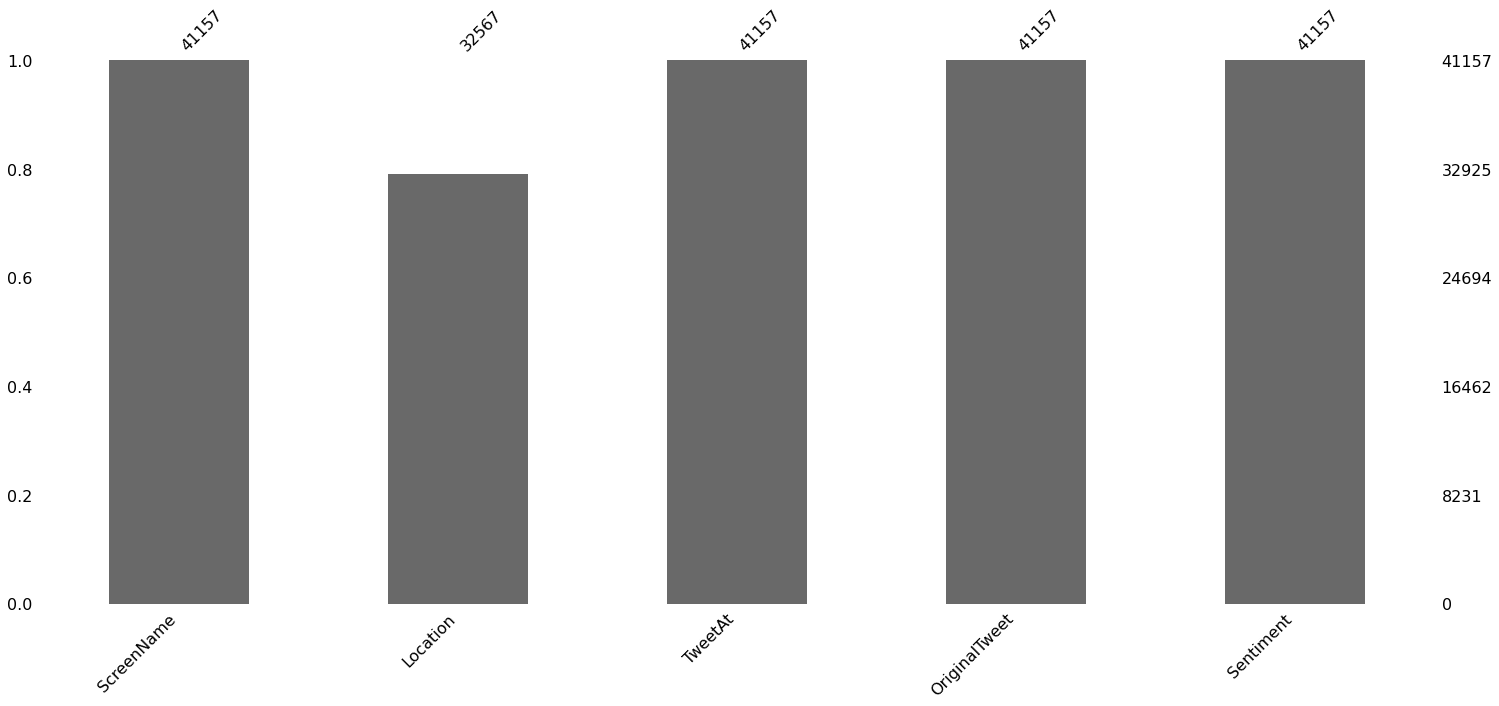

In [20]:
msno.bar(train)

Како што се гледа има NaN values во "Location" колоната и затоа нема да се користи heatmap-a , бидејќи ако имаше  NaN values и во други колони ќе се видеше корелацијата помеѓу вредностите 

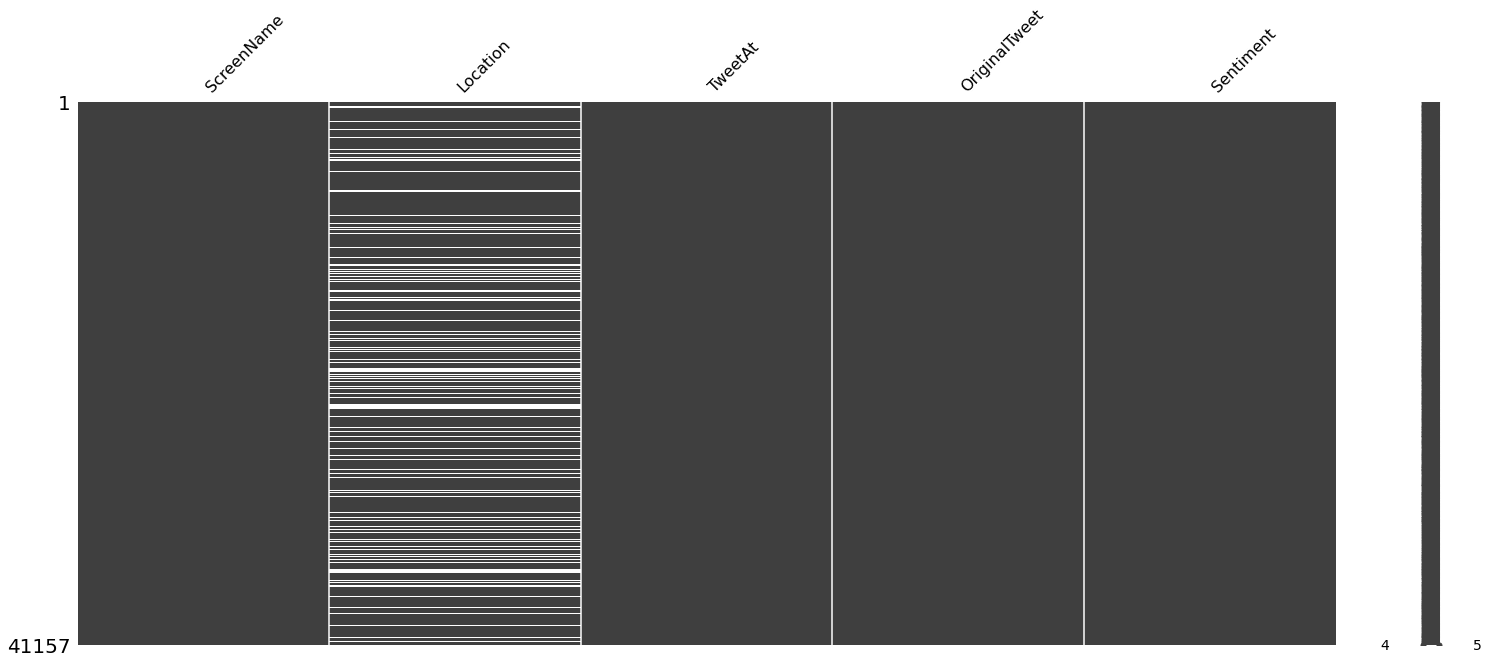

In [21]:
msno.matrix(train)

In [22]:
missing_values_train = train.isnull().sum()
percent_train_missing_values=missing_values_train/len(train) *100
missing_values_train=pd.concat([missing_values_train,percent_train_missing_values],axis=1)
missing_values_train.columns=['Num. of missing values','% of missing values']
missing_values_train

,Num. of missing values,% of missing values
ScreenName,0,0.000000
Location,8590,20.871298
TweetAt,0,0.000000
OriginalTweet,0,0.000000
Sentiment,0,0.000000


In [23]:
missing_values_test = test.isnull().sum()
percent_test_missing_values=missing_values_test/len(test) *100
percent_test_missing_values

ScreenName        0.000000
Location         21.958926
TweetAt           0.000000
OriginalTweet     0.000000
Sentiment         0.000000
dtype: float64

In [24]:
train1=train.copy()

In [25]:
train1.dropna(subset=['Location'],how='any',inplace=True)
train1.Location.isnull().sum()

0

In [26]:
test1=test.copy()

In [27]:
test1.dropna(subset=['Location'],how='any',inplace=True)
test1.Location.isnull().sum()

0

In [28]:
train.shape

(41157, 5)

In [29]:
train.Location.isnull().sum()

8590

In [30]:
print("deleted:",41157-8590)

deleted: 32567


In [31]:
test.shape

(3798, 5)

In [32]:
test.Location.isnull().sum()

834

In [33]:
print("deleted:",3798-834)

deleted: 2964


Во овој дел се прави preprocessing на tweets. Се избришат urls,html links,пункциските знаци,броевите и сите tweets да се во Lower casing

In [34]:
# Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

# Lower casing
def lower(text):
    low_text = text.lower()
    return low_text

# Number removal
def remove_num(text):
    remove = re.sub(r'\d+', '' ,text)
    return remove
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str


train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: remove_urls(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: remove_html(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: lower(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: remove_num(x))
train['OriginalTweet'] = train['OriginalTweet'].apply(lambda x: punctuation_removal(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: remove_urls(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: remove_html(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: lower(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: remove_num(x))
test['OriginalTweet'] = test['OriginalTweet'].apply(lambda x: punctuation_removal(x))

Се бројат твитовите по карактери

In [35]:
train['text_length']=train['OriginalTweet'].apply(len)

In [36]:
train.head()

,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text_length
0,48751,London,2020-03-16,menyrbie philgahan chrisitv and and,Neutral,38
1,48752,UK,2020-03-16,advice talk to your neighbours family to excha...,Positive,237
2,48753,Vagabonds,2020-03-16,coronavirus australia woolworths to give elder...,Positive,103
3,48754,NaN,2020-03-16,my food stock is not the only one which is emp...,Positive,260
4,48755,NaN,2020-03-16,me ready to go at supermarket during the covid...,Extremely Negative,267


Тука се гледа дали би требало зборовите да се скратат или не 

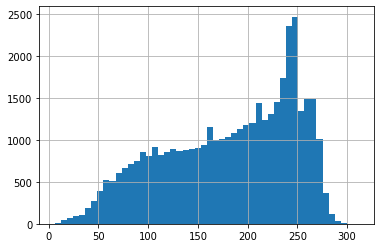

In [37]:
train['text_length'].hist(bins=50)

Тука проверуваме колку имаме Sentimenti

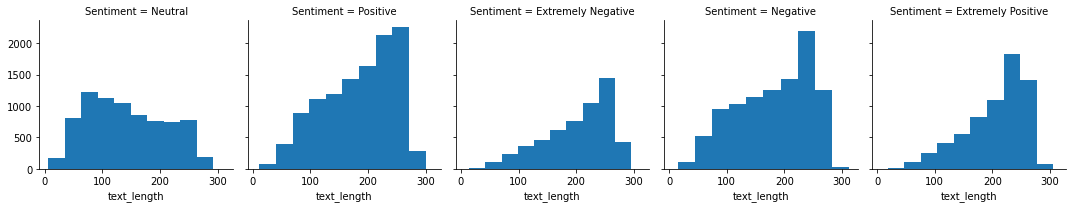

In [38]:
g = sns.FacetGrid(train,col='Sentiment')
g.map(plt.hist,'text_length')

In [39]:
#direct encryption
y=pd.get_dummies(train['Sentiment'])

OneHot Encoding

Sentimenti се лаберирани со користење на get_dummies 

In [40]:
y

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
41152,0,0,0,1,0
41153,1,0,0,0,0
41154,0,0,0,0,1
41155,0,0,0,1,0


In [41]:
x=train['OriginalTweet']

In [42]:
test['text_length']=test['OriginalTweet'].apply(len)

In [43]:
#директна енкрипција од стрингови во бројки
yTest = pd.get_dummies(test['Sentiment'])
yTest

,Extremely Negative,Extremely Positive,Negative,Neutral,Positive
0,1,0,0,0,0
1,0,0,0,0,1
2,0,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,0
...,...,...,...,...,...
3793,0,0,0,0,1
3794,0,0,1,0,0
3795,0,0,0,1,0
3796,1,0,0,0,0


In [44]:
X_train=train['OriginalTweet']
X_test=test['OriginalTweet']
#########
Y_train=y
Y_test=yTest

text--> vector

Поделба на податоците

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size = 0.20,random_state=1)

In [46]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(32925,) (8232,) (32925, 5) (8232, 5)


# Tokenization

Ги токенизираме што значи за секој збор да добиеме број.Токенизирани се со 10000 зборчиња

In [47]:
tokenizer = Tokenizer(num_words=10000)

In [48]:
tokenizer.fit_on_texts(X_train)

In [49]:
X_train = tokenizer.texts_to_sequences(X_train)

In [50]:
X_train

[[62,
  68,
  14,
  68,
  49,
  1523,
  34,
  356,
  46,
  59,
  442,
  4,
  4,
  31,
  52,
  2,
  1635,
  1019,
  2,
  6625,
  7,
  1778,
  1934,
  1435,
  33,
  4,
  9,
  1504,
  7918],
 [159,
  16,
  215,
  137,
  98,
  65,
  37,
  348,
  147,
  42,
  677,
  51,
  48,
  42,
  649,
  47,
  2046,
  106,
  402,
  26,
  42,
  1,
  1086,
  5,
  787,
  1580,
  194,
  13,
  10,
  3709,
  13,
  52,
  14,
  45,
  3196,
  34,
  10],
 [2429,
  5126,
  9,
  381,
  1255,
  3710,
  38,
  212,
  69,
  24,
  38,
  81,
  73,
  11,
  2157,
  650,
  1455,
  158,
  1935,
  1420,
  3089],
 [27,
  325,
  1,
  307,
  1349,
  22,
  39,
  7919,
  360,
  31,
  615,
  472,
  2158,
  8,
  2379,
  2,
  122,
  1,
  6155,
  504,
  5,
  1064,
  5127,
  4],
 [220,
  198,
  2,
  2249,
  43,
  1,
  19,
  310,
  1141,
  13,
  1,
  175,
  5,
  6,
  853,
  19,
  441,
  4271,
  311,
  749,
  45,
  103,
  28,
  498,
  8,
  86,
  20,
  5,
  1,
  1478,
  32,
  17,
  593,
  5,
  58,
  1020,
  651,
  50,
  1306,
  13,
  504,


In [51]:
X_test=tokenizer.texts_to_sequences(X_test)

In [52]:
total=[len(text) for text in X_train]

In [53]:
total

[29,
 37,
 21,
 24,
 46,
 30,
 47,
 37,
 39,
 27,
 24,
 18,
 28,
 20,
 32,
 50,
 17,
 40,
 24,
 28,
 34,
 36,
 24,
 23,
 37,
 11,
 24,
 12,
 6,
 23,
 48,
 25,
 11,
 22,
 46,
 21,
 25,
 4,
 9,
 6,
 26,
 31,
 17,
 35,
 36,
 24,
 29,
 41,
 15,
 18,
 29,
 32,
 30,
 16,
 40,
 21,
 25,
 37,
 45,
 21,
 40,
 29,
 47,
 23,
 16,
 10,
 36,
 15,
 38,
 20,
 45,
 15,
 43,
 6,
 42,
 21,
 14,
 31,
 47,
 21,
 41,
 21,
 45,
 7,
 28,
 11,
 38,
 26,
 26,
 19,
 15,
 29,
 47,
 13,
 25,
 29,
 31,
 15,
 39,
 12,
 8,
 40,
 30,
 26,
 31,
 25,
 37,
 26,
 33,
 30,
 33,
 37,
 13,
 27,
 20,
 9,
 34,
 23,
 39,
 29,
 25,
 28,
 37,
 44,
 24,
 7,
 32,
 19,
 22,
 20,
 17,
 25,
 13,
 32,
 22,
 31,
 8,
 9,
 32,
 41,
 15,
 41,
 11,
 38,
 10,
 36,
 25,
 20,
 8,
 27,
 36,
 33,
 15,
 41,
 14,
 35,
 27,
 20,
 19,
 27,
 52,
 30,
 18,
 10,
 17,
 55,
 33,
 29,
 33,
 21,
 25,
 45,
 23,
 20,
 29,
 42,
 40,
 41,
 23,
 10,
 38,
 29,
 35,
 39,
 11,
 21,
 27,
 24,
 40,
 29,
 34,
 30,
 37,
 13,
 38,
 38,
 37,
 43,
 47,
 13,
 23,
 41,
 4

(array([  32.,  105.,  222.,  558.,  929., 1209., 1357., 1384., 1472.,
        1512., 1602., 1682., 1678., 1730., 1871., 1960., 2062., 2029.,
        2012., 1950., 1682., 1350.,  950.,  700.,  444.,  247.,  126.,
          45.,   17.,    8.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
        52., 54., 56., 58., 60.]),
 <a list of 30 Patch objects>)

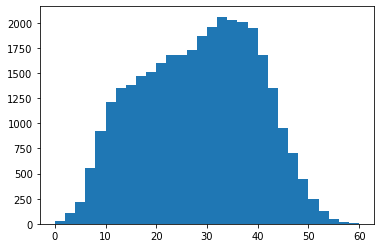

In [54]:
plt.hist(total,bins=30)

In [55]:
np.average(total)

27.8131814730448

Бидејќи зборовите имат различна должина  им правиме padding od max_words=28 се зема како нај фреквентна должина

In [56]:
max_words=28 

pad_sequences ќе помогне пример ако имаме max=6

12 5 0 0 0 0 - ке треба да стави 0 
а ако има повеќе од максималното да ги скрати пример 

13 4 6 7 8 9 8 33 - 8 и 33 ќе ги скрати

Значи додава или скратува дадената реченица

In [57]:
X_train = sequence.pad_sequences(X_train,maxlen=max_words)

In [58]:
X_test = sequence.pad_sequences(X_test,maxlen=max_words)

In [59]:
total=[len(text) for text in X_train]
total

[28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,


# Define Keras Model

In [60]:
model = Sequential()

In [61]:
from keras.layers import Embedding,Conv1D,MaxPooling1D,LSTM

In [62]:
model.add(Embedding(10000,150,input_length=28))

-----

In [63]:
model.add(Conv1D(filters=32,kernel_size=3,padding='same',activation='relu'))

In [64]:
model.add(MaxPooling1D(pool_size=2))

In [65]:
model.add(Conv1D(filters=32,kernel_size=3,padding='same',activation='relu'))

In [66]:
model.add(MaxPooling1D(pool_size=2))

In [67]:
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))

-----

In [68]:
from keras.layers import Activation, Dense
model.add(Dense(5,activation='softmax'))
#broj na nevroni 5 bidejki imame negative,positive,neutral,extremely negatve,extremely positive

#### Compile Keras Model

In [69]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 150)           1500000   
                                                                 
 conv1d (Conv1D)             (None, 28, 32)            14432     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 100)               5

#### Fit Keras Model

In [71]:
history=model.fit(X_train,Y_train,epochs=10,batch_size=120,validation_split=0.2)

Epoch 1/10
220/220 [==============================] - 16s 57ms/step - loss: 1.3233 - val_loss: 1.0069
Epoch 2/10
220/220 [==============================] - 12s 55ms/step - loss: 0.8553 - val_loss: 0.8907
Epoch 3/10
220/220 [==============================] - 12s 54ms/step - loss: 0.6755 - val_loss: 0.9045
Epoch 4/10
220/220 [==============================] - 12s 55ms/step - loss: 0.5351 - val_loss: 0.9996
Epoch 5/10
220/220 [==============================] - 12s 54ms/step - loss: 0.3972 - val_loss: 1.1792
Epoch 6/10
220/220 [==============================] - 13s 59ms/step - loss: 0.2891 - val_loss: 1.4012
Epoch 7/10
220/220 [==============================] - 12s 55ms/step - loss: 0.2209 - val_loss: 1.5429
Epoch 8/10
220/220 [==============================] - 12s 54ms/step - loss: 0.1834 - val_loss: 1.7155
Epoch 9/10
220/220 [==============================] - 12s 54ms/step - loss: 0.1361 - val_loss: 1.7937
Epoch 10/10
220/220 [==============================] - 14s 65ms/step - loss: 0.106

#### Evaluate Keras Model

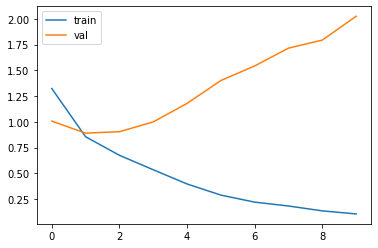

In [72]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])

In [73]:
y_pred=model.predict(X_test)

In [74]:
y_pred=y_pred.round()

In [75]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1087
           1       0.76      0.53      0.62      1331
           2       0.52      0.60      0.56      2004
           3       0.76      0.62      0.68      1554
           4       0.55      0.63      0.59      2256

   micro avg       0.61      0.60      0.61      8232
   macro avg       0.65      0.60      0.62      8232
weighted avg       0.63      0.60      0.61      8232
 samples avg       0.60      0.60      0.60      8232



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
cnf=confusion_matrix(np.argmax(list(Y_test.values),axis=1),np.argmax(y_pred,axis=1))

In [77]:
Y_test.values

array([[1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

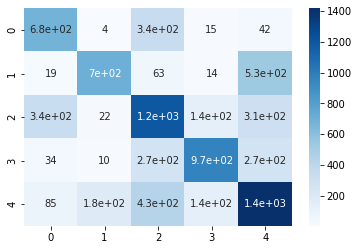

In [78]:
sns.heatmap(cnf,cmap='Blues',annot=True)

In [79]:
print(f1_score(Y_test,y_pred,average='macro'))

0.6157302658250249


# Word2Vec model

## Corpus prepration

In [80]:
texts=train['OriginalTweet']

In [81]:
matrix=[]

In [82]:
for text in texts:
  words=text.split(" ")
  matrix.append(words)

In [83]:
matrix

[['menyrbie', 'philgahan', 'chrisitv', '', 'and', '', 'and', ''],
 ['advice',
  'talk',
  'to',
  'your',
  'neighbours',
  'family',
  'to',
  'exchange',
  'phone',
  'numbers',
  'create',
  'contact',
  'list',
  'with',
  'phone',
  'numbers',
  'of',
  'neighbours',
  'schools',
  'employer',
  'chemist',
  'gp',
  'set',
  'up',
  'online',
  'shopping',
  'accounts',
  'if',
  'poss',
  'adequate',
  'supplies',
  'of',
  'regular',
  'meds',
  'but',
  'not',
  'over',
  'order'],
 ['coronavirus',
  'australia',
  'woolworths',
  'to',
  'give',
  'elderly',
  'disabled',
  'dedicated',
  'shopping',
  'hours',
  'amid',
  'covid',
  'outbreak',
  ''],
 ['my',
  'food',
  'stock',
  'is',
  'not',
  'the',
  'only',
  'one',
  'which',
  'is',
  'empty\r\r\n\r\r\nplease',
  'dont',
  'panic',
  'there',
  'will',
  'be',
  'enough',
  'food',
  'for',
  'everyone',
  'if',
  'you',
  'do',
  'not',
  'take',
  'more',
  'than',
  'you',
  'need',
  '\r\r\nstay',
  'calm',
  's

In [84]:
sentences=[]

In [85]:
for text in texts:
  sent=text.split("\n")
  sentences.append(sent)

In [86]:
sentences

[['menyrbie philgahan chrisitv  and  and '],
 ['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order'],
 ['coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid outbreak '],
 ['my food stock is not the only one which is empty\r\r',
  '\r\r',
  'please dont panic there will be enough food for everyone if you do not take more than you need \r\r',
  'stay calm stay safe\r\r',
  '\r\r',
  'covidfrance covid covid coronavirus confinement confinementotal confinementgeneral '],
 ['me ready to go at supermarket during the covid outbreak\r\r',
  '\r\r',
  'not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage\r\r',
  '\r\r',
  'coronavirusfrance restezchezvous stayathome confinement '

#### W2V Model

In [87]:
from gensim.models import Word2Vec

Train model

In [88]:
model2 = Word2Vec(matrix,size=150,min_count=1,window=5,workers=4)

In [89]:
model2["virus"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.7841988 , -1.1551714 ,  0.6315076 , -0.6964653 ,  1.5417119 ,
        0.54535824,  1.1611799 ,  1.6244887 , -0.56068736,  0.5885732 ,
       -0.6790499 , -0.21793774,  0.29217905, -0.27404886,  0.18530299,
       -0.08464264,  0.35506102, -0.40341166, -1.0996792 ,  0.11806267,
       -0.25646567,  1.0320979 ,  0.75586605,  1.1475546 , -0.97287524,
        0.3657623 ,  0.04931404,  0.92956096, -0.0895459 ,  0.07927373,
        1.6942139 , -0.6649776 ,  0.51095533, -0.48730928, -0.4165312 ,
       -0.21424176, -0.29156476, -0.18190975, -1.6841486 , -0.25132614,
       -0.17598884,  0.18847568, -1.4230764 , -0.68502   , -0.3444166 ,
        0.54060584,  0.5742787 ,  0.6625844 , -1.5278654 , -1.9465361 ,
       -0.9472527 , -1.4701532 , -1.1165018 ,  0.3133849 , -1.2892994 ,
        0.5691568 , -0.16187717, -1.4611326 , -0.44704005,  0.04944488,
        0.05667467, -0.03478099, -0.89436185,  0.245604  , -0.13938949,
        0.36320624, -0.8220275 , -0.5135762 , -0.24261573,  0.01

In [90]:
#model.wv.vocab
X=model2[model2.wv.vocab]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [91]:
model2[model2.wv.vocab]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([[-0.00209142,  0.00384383,  0.00342604, ..., -0.00871864,
        -0.00342847, -0.00758461],
       [-0.00902972,  0.00471453,  0.00139064, ..., -0.01588035,
        -0.00280958, -0.00525768],
       [ 0.01319441,  0.00760346,  0.01285163, ..., -0.02627851,
        -0.00734122, -0.01907322],
       ...,
       [-0.00928162,  0.0039473 ,  0.01660916, ...,  0.00735498,
        -0.00594649, -0.00869311],
       [-0.00617219,  0.00102325,  0.01168892, ..., -0.00263526,
        -0.00847835, -0.00335796],
       [-0.00149568,  0.00543674,  0.00573853, ...,  0.01012419,
        -0.00028176,  0.00115617]], dtype=float32)

За да правиме било каква визуелизација во 2D ќе ни треба некој Dimensionality reduction,вредностите ќе треба да се намалат па затоа ќе користеме од decomposition - PCA 

In [92]:
from sklearn.decomposition import PCA

In [93]:
# fit a 2d PCA model to the vectors
pca=PCA(n_components=2)

In [94]:
result=pca.fit_transform(X)

In [95]:
result

array([[-0.18328013,  0.05202274],
       [-0.18087754,  0.05310773],
       [-0.09877733,  0.00686592],
       ...,
       [-0.19212644,  0.05409979],
       [-0.18776228,  0.04427148],
       [-0.24201772,  0.10474156]], dtype=float32)

###  Metadata and vectors saving

In [96]:
# Vector file, `\t` seperated the vectors and `\n` seperate the words
out_vector=io.open('/content/drive/MyDrive/Seminarska/out_vec.tsv','w',encoding='utf-8')
# Meta data file, `\n` seperated word
out_metadata=io.open('/content/drive/MyDrive/Seminarska/out_meta.tsv','w',encoding='utf-8')

In [97]:
model2.wv.index2word

['',
 'the',
 'to',
 'and',
 'of',
 'covid',
 'a',
 'in',
 'coronavirus',
 'for',
 'is',
 'are',
 'on',
 'you',
 'i',
 'at',
 'this',
 'prices',
 'food',
 'supermarket',
 'store',
 'with',
 'that',
 'grocery',
 'have',
 'as',
 'we',
 'be',
 'it',
 'people',
 'from',
 'amp',
 'all',
 'your',
 'not',
 'will',
 'consumer',
 'my',
 'our',
 'has',
 'up',
 'out',
 'they',
 'by',
 'can',
 'or',
 'more',
 'shopping',
 'but',
 'if',
 'online',
 'how',
 'their',
 'during',
 'so',
 'pandemic',
 'now',
 'get',
 'no',
 'about',
 'who',
 'need',
 'what',
 'us',
 'just',
 'workers',
 'panic',
 'like',
 'do',
 'was',
 'an',
 'when',
 'time',
 'sanitizer',
 'go',
 'demand',
 'home',
 'some',
 'help',
 'hand',
 'there',
 'its',
 's',
 'going',
 'stock',
 'one',
 'due',
 'me',
 'been',
 'new',
 'oil',
 'buying',
 'work',
 'crisis',
 'them',
 'here',
 'please',
 'after',
 'other',
 'toilet',
 'toiletpaper',
 'because',
 'than',
 'these',
 'only',
 'should',
 'retail',
 'local',
 'over',
 'paper',
 'stay',

In [98]:
model2.wv[model2.wv.index2word[2]]

array([-0.75504917, -0.09186663, -0.31226623,  1.4306415 ,  0.56401175,
        3.009793  , -0.6515833 ,  0.7085807 ,  0.16347516,  0.6386168 ,
       -1.0902816 ,  0.30404186,  1.816894  ,  1.700973  , -1.3086162 ,
       -1.1393833 , -0.6920357 , -0.7528006 , -1.7831571 , -1.2199503 ,
        0.08552688, -0.86869216,  1.7139486 ,  0.46673787, -1.8652819 ,
       -0.39450523, -0.9595767 ,  0.11081629, -1.4460446 ,  0.03672747,
        0.23060144,  0.7951378 ,  0.562093  ,  0.9906702 ,  1.1714636 ,
        3.2229805 , -2.001123  , -0.15383095, -2.0065444 ,  0.56280744,
       -0.7685857 ,  0.94970584, -1.1394266 ,  0.30144   , -2.9469159 ,
        1.8629853 ,  2.2782893 , -0.23474607,  0.28623295, -1.1990633 ,
        0.13871253, -0.6210182 ,  0.13105465,  0.9175845 ,  1.4077936 ,
        0.9876335 , -0.96869946,  0.25978792,  0.9128873 , -0.48559424,
       -0.0330758 , -2.2274258 , -2.1607885 ,  0.669312  ,  1.0356303 ,
       -0.7071127 , -0.6377645 ,  0.24702509,  0.38545823, -1.05

In [99]:
# Write meta file and vector file
for index in range(0,len(model2.wv.index2word)):
  word = model2.wv.index2word[index]
  vec = model2.wv[word]
  out_metadata.write(word+"\n")
  out_vector.write("\t".join([str(x) for x in vec])+"\n")

In [100]:
out_vector.close()

In [101]:
out_metadata.close()

####Visualization of the embeddings

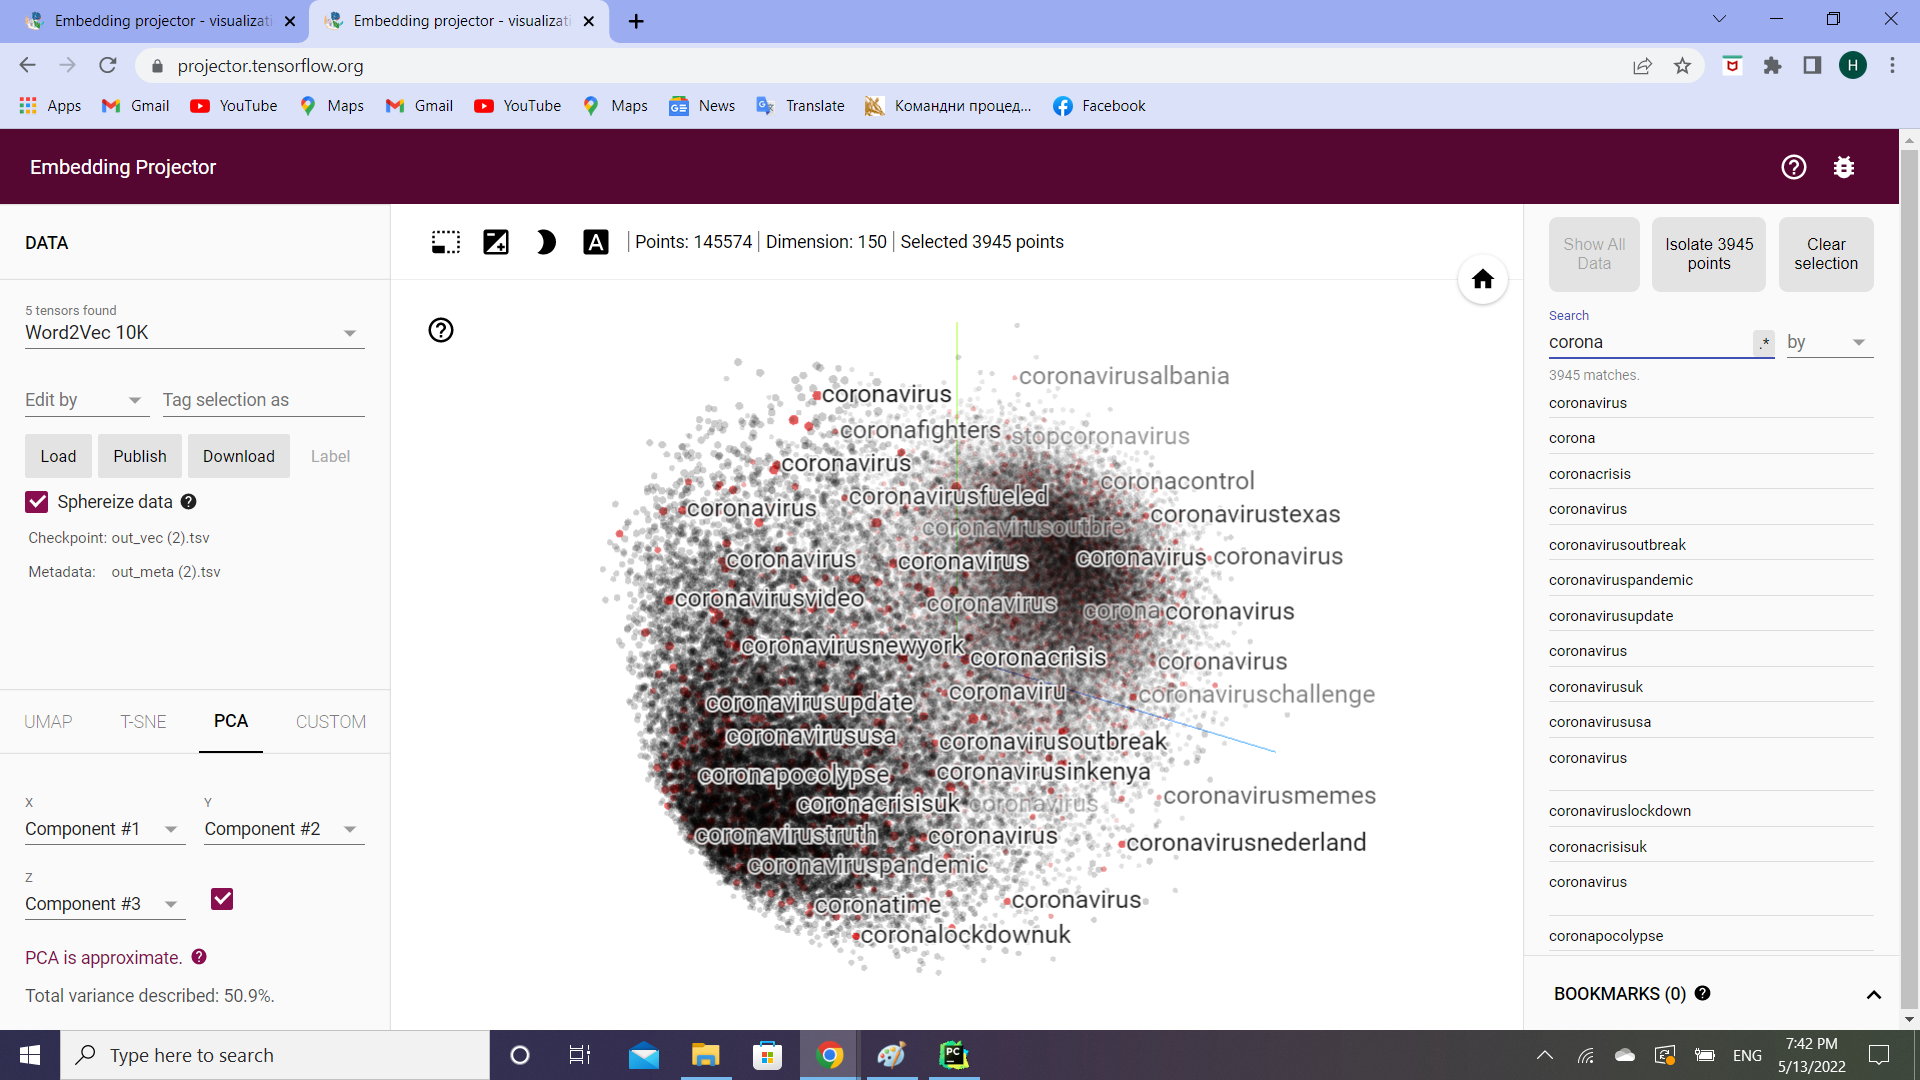

## Named Entity Recognition

*In Natural language processing, Named Entity
Recognition (NER) is a process where a
sentence or a chunk of text is parsed through
to find entities that can be put under categories
like names, organizations, locations, quantities,
monetary values, percentages, etc.* 

In [102]:
import spacy
import en_core_web_sm

In [103]:
nlp = en_core_web_sm.load()

In [104]:
doc=nlp(train['OriginalTweet'][0])

In [105]:
print([(X.text,X.label_) for X in doc.ents])

[('menyrbie philgahan chrisitv', 'PERSON')]


In [106]:
from spacy import displacy

In [107]:
displacy.render(nlp(train['OriginalTweet'][10]),jupyter=True,style='ent')

In [108]:
displacy.render(nlp(train['OriginalTweet'][50]),jupyter=True,style='dep')

# Clustering

###Universal Sentece Encoder

In [129]:
!pip install transformers 

In [110]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train['Sentiment']=encoder.fit_transform(train['Sentiment'])

In [111]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [112]:
# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(train.OriginalTweet.values)

In [125]:
message_embeddings
#за секој текст различен вектор 

<tf.Tensor: shape=(41157, 512), dtype=float32, numpy=
array([[ 0.04149898,  0.01656727,  0.02402631, ..., -0.06145813,
         0.01962487, -0.02520274],
       [-0.01134651, -0.027404  ,  0.03221354, ...,  0.05568726,
        -0.01364039,  0.01919795],
       [-0.03254348, -0.02351973, -0.02513446, ..., -0.03481843,
        -0.03663005,  0.02702788],
       ...,
       [-0.012643  , -0.07477579, -0.03031807, ...,  0.05384207,
        -0.05789706,  0.03921837],
       [ 0.02339545,  0.02303968, -0.03338026, ..., -0.0309152 ,
        -0.00209947, -0.03829345],
       [-0.05280301, -0.07510798, -0.00711939, ...,  0.04919859,
        -0.0162812 , -0.00168532]], dtype=float32)>

###K-Means Clustering

In [128]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5)
km.fit(message_embeddings)

KMeans(n_clusters=5)

In [130]:
clusters = km.labels_.tolist()

In [126]:
clusters

[1,
 0,
 3,
 3,
 3,
 0,
 3,
 3,
 3,
 2,
 3,
 3,
 0,
 3,
 1,
 3,
 1,
 1,
 3,
 2,
 1,
 2,
 1,
 1,
 3,
 4,
 2,
 0,
 1,
 3,
 3,
 2,
 2,
 0,
 1,
 0,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 2,
 3,
 2,
 3,
 3,
 1,
 3,
 1,
 3,
 3,
 0,
 4,
 1,
 0,
 3,
 2,
 1,
 1,
 1,
 3,
 3,
 1,
 3,
 1,
 0,
 0,
 0,
 3,
 3,
 1,
 4,
 1,
 1,
 3,
 2,
 1,
 3,
 3,
 1,
 4,
 1,
 1,
 3,
 1,
 2,
 3,
 0,
 0,
 3,
 1,
 3,
 3,
 1,
 0,
 0,
 3,
 0,
 3,
 3,
 3,
 0,
 4,
 0,
 1,
 2,
 1,
 3,
 3,
 3,
 3,
 1,
 2,
 3,
 3,
 2,
 1,
 1,
 2,
 0,
 3,
 3,
 0,
 3,
 2,
 3,
 0,
 1,
 1,
 3,
 3,
 3,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 2,
 3,
 2,
 3,
 0,
 3,
 3,
 3,
 1,
 3,
 0,
 0,
 0,
 2,
 0,
 3,
 1,
 0,
 3,
 3,
 3,
 3,
 2,
 3,
 1,
 3,
 0,
 3,
 3,
 3,
 1,
 3,
 1,
 3,
 1,
 3,
 1,
 1,
 0,
 3,
 3,
 1,
 3,
 0,
 4,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 4,
 3,
 2,
 1,
 3,
 2,
 2,
 2,
 1,
 4,
 1,
 2,
 2,
 2,
 1,
 1,
 3,
 3,
 3,
 1,
 3,
 2,
 1,
 2,
 3,
 3,
 0,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 3,
 3,
 3,
 0,
 1,
 1,
 0,
 3,
 3,
 2,
 3,
 1,
 2,
 3,
 3,
 2,
 1,
 3,
 1,
 3,
 0,
 1,


In [131]:
from sklearn.metrics.cluster import v_measure_score

In [132]:
v_measure_score(train.Sentiment.values,clusters)

0.018925437286164443

#### Visualization

#### Dimensionality reduction

In [115]:
from sklearn.decomposition import PCA
import numpy as np


data = message_embeddings
pca = PCA(2)
 
#Transform the data
df_new = pca.fit_transform(data)

#### Cluster training

In [116]:
#Initialize the class object
kmeans = KMeans(n_clusters=5)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df_new)
 
#Getting unique labels
u_labels = np.unique(label)
 
labels = kmeans.labels_

####Visualization of the clusters


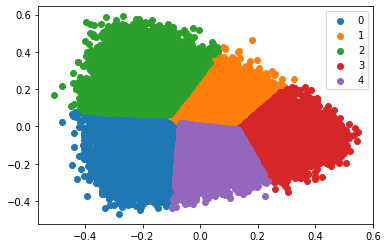

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#plotting the results:
for i in u_labels:
    plt.scatter(df_new[label == i , 0] , df_new[label == i , 1] , label = i)
plt.legend()
plt.show()

###Agglomerative Clustering

##### Dimensionality reduction

In [118]:
from sklearn.decomposition import PCA
import numpy as np


data = message_embeddings
pca = PCA(2)
 
#Transform the data
df_new = pca.fit_transform(data)

#### Cluster training

In [119]:
from sklearn.cluster import AgglomerativeClustering

In [120]:
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(df_new, n_neighbors=10, include_self=False)

In [121]:
model = AgglomerativeClustering(n_clusters=5, connectivity=connectivity, linkage='ward').fit(df_new) 

In [122]:
clusters = model.labels_.tolist() 

In [123]:
model.labels_ 

array([1, 0, 3, ..., 0, 0, 2])

#### Visualization of the clusters

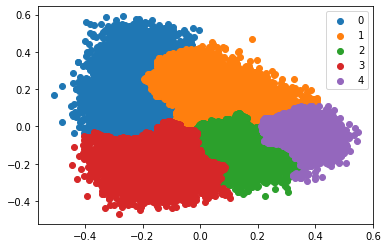

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

label = model.fit_predict(df_new)

u_labels = np.unique(label)

#plotting the results:
for i in u_labels:
    plt.scatter(df_new[label == i , 0] , df_new[label == i , 1] , label = i)
plt.legend()
plt.show()